**DOWNLOAD THE DATASET**

In this project, we will use a set of synthetic data that represents the physiological monitoring of the patients in an Intensive Care Unit (ICU).

We download the data and add the data to the COLAB Notebook.

In [ ]:
%pip install googledrivedownloader
from googledrivedownloader import download_file_from_google_drive
import zipfile

download_file_from_google_drive(file_id='1E6hZQqk-W0FWseLrgI6RVeUi3D0rcsHP',
                                dest_path='./ehealth_lab_5.zip',
                                unzip=False,
                                overwrite=True)

with zipfile.ZipFile("./ehealth_lab_5.zip","r") as zip_ref:
    zip_ref.extractall("./ehealth_lab_5")

path_to_dataset_folder = "./ehealth_lab_5/"

We import some Python packages.

In [ ]:
import pathlib
import os
import copy
import random
import scipy
import sklearn
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

We define two methods for displaying the results.

In [ ]:
def plot_boxplot(data_distributions: list,
                  data_labels: np.ndarray,
                  ylabel: str,
                  xlabel: str,
                  title: str = None):

  fig = plt.figure()
  plt.boxplot(data_distributions, tick_labels=data_labels)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.grid()

  if title is not None:
    plt.title(title)

  fig.tight_layout()

In [ ]:
def plot_barplot(data_values: list,
                 data_labels: list,
                 xlabel: str,
                 ylabel: str,
                 title: str = None):

  fig = plt.figure()
  plt.bar(data_labels, data_values)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid()

  if title is not None:
    plt.title(title)

**DATASET DESCRIPTION**

Our dataset is organized into three files:

*  `data` is a dictionary containing the elements of the dataset, each key is associated with a unique ID;
*  `data_patient_ids` is a dictionary containing the patient IDs associated with each element of the dataset;
*  `data_labels` is a dictionary containing the labels associated with each element of the dataset.



In [ ]:
data = np.load(path_to_dataset_folder + 'data.npy', allow_pickle=True).item()
data_patient_ids = np.load(path_to_dataset_folder + 'data_patient_ids.npy', allow_pickle=True).item()
data_labels = np.load(path_to_dataset_folder + 'data_labels.npy', allow_pickle=True).item()

Each element in the dataset is associated with a unique identifier.

In [ ]:
data_idxs = list(data.keys())
print(data_idxs)

[1, 3, 8, 19, 20, 21, 22, 24, 25, 29, 30, 32, 35, 39, 43, 51, 53, 56, 60, 62, 64, 68, 69, 70, 72, 73, 74, 83, 85, 86, 87, 93, 94, 99, 103, 106, 110, 114, 134, 137, 138, 141, 143, 147, 148, 150, 151, 152, 154, 164, 165, 166, 174, 177, 184, 194, 199, 201, 202, 208, 219, 227, 228, 233, 234, 238, 239, 245, 250, 256, 257, 259, 263, 264, 272, 275, 276, 280, 284, 291, 294, 297, 300, 311, 314, 322, 324, 326, 329, 330, 336, 342, 343, 352, 353, 357, 360, 361, 363, 365, 371, 376, 379, 381, 397, 398, 399, 400, 408, 418, 420, 423, 426, 432, 442, 447, 452, 458, 460, 462, 463, 467, 468, 471, 472, 473, 481, 485, 487, 488, 491, 492, 497, 500, 504, 508, 511, 516, 519, 520, 525, 526, 530, 536, 537, 539, 544, 547, 558, 559, 560, 561, 565, 568, 570, 572, 576, 577, 592, 594, 595, 600, 601, 605, 607, 609, 610, 613, 614, 619, 621, 627, 630, 635, 636, 639, 641, 644, 648, 651, 653, 654, 655, 659, 661, 665, 667, 670, 675, 677, 678, 679, 680, 683, 687, 688, 690, 691, 692, 696, 700, 701, 705, 707, 708, 710, 718, 7

The size of `data` corresponds to the cardinality of our dataset.


In [ ]:
print('Dataset size:', len(data))

Dataset size: 353


We compute the number of unique patient in the dataset.





In [ ]:
unique_patient_ids = []

for data_idx in data.keys():

    if data_patient_ids[data_idx] not in unique_patient_ids:
        unique_patient_ids.append(data_patient_ids[data_idx])

print('Unique patient IDs:', len(unique_patient_ids))

## because we might have multiple tests with the same patient, that is why the unique patients IDs are less than the dataset size!
## it is good to also separate the data in train test not just based on the data, but also based on the patients.

Unique patient IDs: 351


The fact that the number of unique patient IDs is lower than the number of elements denotes that some patients are associated with multiple elements.

Each element of the database is a multivariate time series with eight components and 32 samples, describing how the physiological parameters of the patients change during the 15 minutes just before the Spontaneous Breathing Trial (SBT). In particular, the sampling period, i.e., the time interval between two consecutive samples, is 30 seconds.


In [ ]:
random_key = random.choice(list(data.keys()))
variable_number, sample_number = data[random_key].shape
print('Number of variables:', variable_number) ## different signal components
print('Number of samples:', sample_number) ## sample times

Number of variables: 8
Number of samples: 32


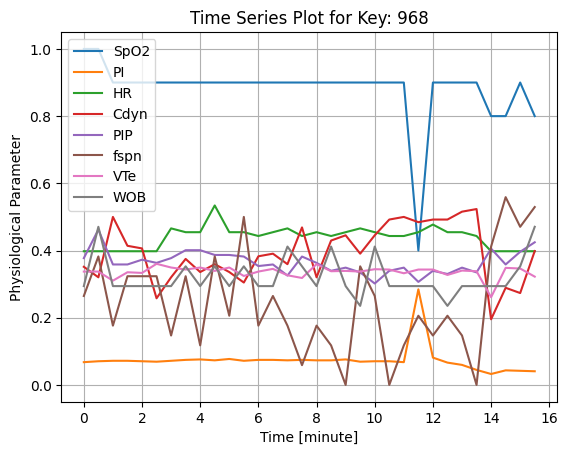

In [ ]:
multivariate_time_series = data[random_key]
sampling_period = 30 # seconds - exactly the same used for the ventillator machine
num_variables, num_samples = multivariate_time_series.shape
time_vector = np.arange(num_samples) * sampling_period / 60

variables = ['SpO2', 'PI', 'HR', 'Cdyn', 'PIP', 'fspn', 'VTe', 'WOB']

plt.figure()
for i in range(num_variables):
  plt.plot(time_vector, multivariate_time_series[i, :], label=variables[i])

plt.xlabel('Time [minute]')
plt.ylabel('Physiological Parameter')
plt.title(f'Time Series Plot for Key: {random_key}')
plt.legend()
plt.grid(True)
plt.show()

Notably, all the variables where normalized between 0 and 1 to enhance the efficiency of classification algorithms.

The labels of the dataset have two possible outcomes:

*   0 denotes that the SBT test was successful;
*   1 denotes that the SBT test failed.


In [ ]:
np.unique(list(data_labels.values()))

array([0, 1])

**SPLITTING THE DATA BETWEEN TRAINING AND VALIDATION**

Before designing the classification algorithm, we divide the data into test and training sets. To do so, we ensure that the data of the same patients belong to a single subset: the data of a patient used to train the algorithm cannot be used to validate the algorithm.

In [ ]:
random.seed(42)

def get_train_split(unique_patient_ids: list, data_idxs: list, data_patient_ids: dict):

  train_positive_idxs = []
  train_negative_idxs = []
  test_positive_idxs = []
  test_negative_idxs = []

## patients are also separated as in one patient must be either in test or train and cannot be in both!

  while len(test_positive_idxs) == 0 or len(test_negative_idxs) == 0:

    shuffled_unique_patient_ids = copy.deepcopy(unique_patient_ids)

    random.shuffle(shuffled_unique_patient_ids)

    # We separate the patient IDs into test and training subset

    test_patient_ids = shuffled_unique_patient_ids[:int(len(unique_patient_ids) * 0.25)]
    train_patient_ids = shuffled_unique_patient_ids[int(len(unique_patient_ids) * 0.25):]
    ## 25% in the test and the remaining in the training set.

    # We divde also the data according with the same framework

    for data_idx in data_idxs:

        if data_patient_ids[data_idx] in test_patient_ids:

            if data_labels[data_idx] == 1:
                test_positive_idxs.append(data_idx)
            else:
                test_negative_idxs.append(data_idx)

        elif data_patient_ids[data_idx] in train_patient_ids:

            if data_labels[data_idx] == 1:
                train_positive_idxs.append(data_idx)
            else:
                train_negative_idxs.append(data_idx)

        else:

            raise ValueError

    train_idxs = np.concatenate((train_positive_idxs, train_negative_idxs))

    test_idxs = np.concatenate((test_positive_idxs, test_negative_idxs))

  return train_idxs, test_idxs

In [ ]:
train_idxs, test_idxs = get_train_split(unique_patient_ids, data_idxs, data_patient_ids)

train_size = len(train_idxs)
test_size = len(test_idxs)

print('Train size:', train_size)
print('Test size:', test_size)

Train size: 265
Test size: 88


**AGGREGATING THE DECISIONS OF MULTIPLE CLASSIFIERS**

We want to design a classifier to predict the outcome of the SBT by using some features derived from the multivariate time series. To this goal, we describe the time series with a set of pre-determined, i.e., hand-crafted, features.

In [ ]:
def get_features_per_variable(data: dict, variable_number: int):

  data_features_per_variable = {}

  for variable_index in range(variable_number):

    data_features_per_variable[variable_index] = {}

    for data_index in data.keys():

      # Get the raw element

      element = data[data_index]

      element_features = []

      # Get the feature

    ## since the data is normalized, we expect the mean^1=mean is equal to 0.5!

      element_features.append(np.mean(np.power(element[variable_index, :], 2)))

      element_features.append(np.mean(np.power(element[variable_index, :], 3)))

      element_features.append(np.mean(np.power(element[variable_index, :], 4)))

      element_features.append(np.mean(np.power(element[variable_index, :], 5)))

      data_features_per_variable[variable_index][data_index] = np.asarray(element_features)

  return data_features_per_variable

In [ ]:
data_features_per_variable = get_features_per_variable(data, variable_number) ## dictionary of dictionaries. contains 8 different dicts each associated with components of data

We define a Multi-Layer-Perception (MLP) classifier for each physiological parameter in the dataset, i.e., for each component of the multi-variate time series associated with each element of the dataset.

In [ ]:
def get_mlp_classifier_per_variable(data_features_per_variable: dict, data_labels: dict, train_idxs: list, variable_number: int):

  classifier_per_variable = []

  for variable_index in range(variable_number):

    train_features = []
    train_labels = []

    for data_index in train_idxs:

      train_features.append(data_features_per_variable[variable_index][data_index])
      train_labels.append(data_labels[data_index])

    train_features = np.asarray(train_features)
    train_labels = np.asarray(train_labels)

    clf = MLPClassifier(hidden_layer_sizes=(16,), max_iter=500).fit(train_features, train_labels)

    classifier_per_variable.append(clf)

  return classifier_per_variable

In [ ]:
classifier_per_variable = get_mlp_classifier_per_variable(data_features_per_variable, data_labels, train_idxs, variable_number)

We assess the performance of the classifiers by aggregating the decisions of each classifier and then computing the Area Under the ROC Curve (AUC) over the final decision.

In [ ]:
## why auc and not just the accuracy????


def get_auc_score_per_variable(classifier_per_variable: list, data_features_per_variable: dict, data_labels: dict, test_idxs: list, variable_number: int):

  predictions_per_variable = []

  test_labels = []
  for data_index in test_idxs:
    test_labels.append(data_labels[data_index])

  test_labels = np.asarray(test_labels)

  for variable_index in range(variable_number):

    test_features = []

    for data_index in test_idxs:

      test_features.append(data_features_per_variable[variable_index][data_index])

    test_features = np.asarray(test_features)

    clf = classifier_per_variable[variable_index]

    predictions = clf.predict_proba(test_features)[:,1]
    predictions_per_variable.append(predictions)

  mean_predictions = np.mean(predictions_per_variable, axis=0)

  return sklearn.metrics.roc_auc_score(test_labels, mean_predictions)

In [ ]:
mean_auc = get_auc_score_per_variable(classifier_per_variable, data_features_per_variable, data_labels, test_idxs, variable_number)
print('Mean AUC:', mean_auc)

Mean AUC: 0.6138211382113822


**IMPLEMENTING CROSS-VALIDATION**

To enhance the reliability of the results, we can train and validate the classifiers multiple times, each considering a different split of the data between the training and test sets and a different initialization for the classifier. In particular, we define an ad hoc method to implement such a cross-validation scheme while training the decision-aggregation classifier.

In [ ]:
def cross_validation_0(unique_patient_ids: list, data_idxs: list, data_patient_ids: dict,
                       data_features_per_variable: dict, data_labels: dict, variable_number: int,
                       iteration_number: int):

  auc_distribution = []

  for i in range(iteration_number):

    train_idxs, test_idxs = get_train_split(unique_patient_ids, data_idxs, data_patient_ids)
    classifier_per_variable = get_mlp_classifier_per_variable(data_features_per_variable, data_labels, train_idxs, variable_number)
    mean_auc = get_auc_score_per_variable(classifier_per_variable, data_features_per_variable, data_labels, test_idxs, variable_number)

    auc_distribution.append(mean_auc)

  return auc_distribution

In [ ]:
auc_distribution_0 = cross_validation_0(unique_patient_ids, data_idxs, data_patient_ids,
                                        data_features_per_variable, data_labels, variable_number, iteration_number=20)

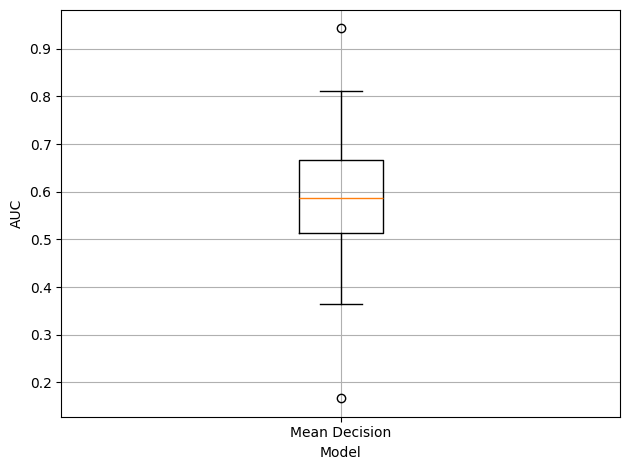

In [ ]:
plot_boxplot([auc_distribution_0],
             ['Mean Decision'],
             'AUC',
             'Model')
plt.show()

**AGGREGATING THE FEATURES OF MULTIPLE SIGNALS**

To try to improve performance, we define a unique classifier that aggregates all the available features, instead of deciding by considering one signal component at a time.

In [ ]:
multivariate_features = {}

for data_index in data_idxs:

  element_features = []

  for variable_index in range(variable_number):

    element_features.append(data_features_per_variable[variable_index][data_index])

  multivariate_features[data_index] = np.concatenate(element_features)

We define an ad hoc method to implement cross-validation for training the feature-aggregation classifier.

In [ ]:
def cross_validation_1(unique_patient_ids: list, data_idxs: list, data_patient_ids: dict,
                       multivariate_features: dict, data_labels: dict, iteration_number: int):

  auc_distribution = []

  for i in range(iteration_number):

    train_idxs, test_idxs = get_train_split(unique_patient_ids, data_idxs, data_patient_ids)

    train_features = []
    train_labels = []

    for data_index in train_idxs:

      train_features.append(multivariate_features[data_index])
      train_labels.append(data_labels[data_index])

    test_features = []
    test_labels = []

    for data_index in test_idxs:

      test_features.append(multivariate_features[data_index])
      test_labels.append(data_labels[data_index])

    clf = MLPClassifier(hidden_layer_sizes=(64,), max_iter=500).fit(train_features, train_labels)

    predictions = clf.predict_proba(test_features)[:,1]

    auc_distribution.append(sklearn.metrics.roc_auc_score(test_labels, predictions))

  return auc_distribution


## here we have single classifier and not 8 different classifiers

In [ ]:
auc_distribution_1 = cross_validation_1(unique_patient_ids, data_idxs, data_patient_ids,
                                        multivariate_features, data_labels, iteration_number = 20)

We compare the performance obtained while using the decision-aggregation framework against the feature-aggregation framework.

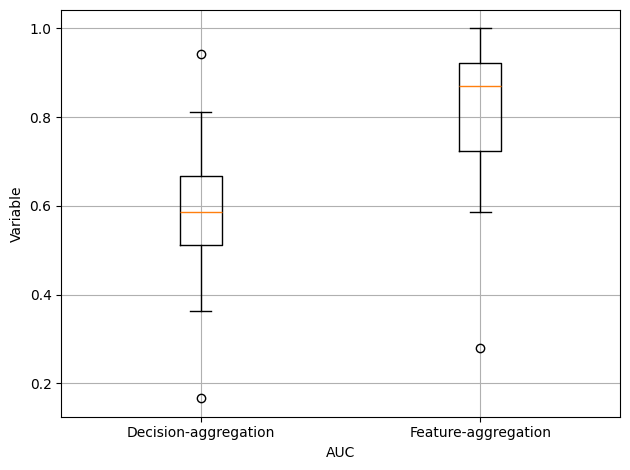

In [ ]:
plot_boxplot([auc_distribution_0, auc_distribution_1],
             ['Decision-aggregation', 'Feature-aggregation'],
             'Variable',
             'AUC')
plt.show()

We have designed two different classification architectures: the first exploits a decision-level aggregation, while the second exploits a feature-level aggregation. Both solutions have the drawback of exploiting hand-crafted features that may not be suitable for describing the signals and may lead to the best classification results.

In the following, you are asked to design a third classifier that processes directly the multivariate signals associated with each patient via a learning model based on a 1D convolutional neural network. To this goal, you need to associate each signal component with a different channel and design a 1-D convolutional kernel that operates over the time domain.

We first import some Python libraries that allow us to work with neural networks.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

To define the convolutional network, you can implement the content of the following method. In particular, you can use the object `Sequential` from `Keras` as a container of multiple layers.

*  The first layers are used for feature extraction and must implement the 1-D convolution operations.
*  The last layers are used for carrying out the classification task and can be standard dense layers.
*  The last neuron of the network must be followed by a sigmoid function that returns a value in [0, 1].

In [ ]:
def get_model(input_shape: tuple):

  # The variable input_shape define the dimensions of the data

  model = Sequential()

  # YOUR CODE

  # Feature Extraction Layers (1D Convolutions)
  model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=input_shape))
  model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
  # Add more Conv1D layers as needed (experiment!)
  model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))

  # Flatten the output before the Dense layers
  model.add(Flatten())

  # Classification Layers (Dense)
  model.add(Dense(units=128, activation='relu')) # Experiment with the number of units
  model.add(Dense(units=1, activation='sigmoid'))  # Output layer for binary classification

  ## model.append(...)

  model.compile(optimizer=Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model

To train and validate the new classifier, you can extend the following method. As done before, you must adopt a cross-validation approach to obtain multiple AUC values and, thus, improve the reliability of the results.

In [ ]:
def cross_validation_2(unique_patient_ids: list, data_idxs: list, data_patient_ids: dict,
                       data: dict, data_labels: dict, iteration_number: int):

  auc_distribution = []

  for i in range(iteration_number):

    train_idxs, test_idxs = get_train_split(unique_patient_ids, data_idxs, data_patient_ids)

    train_data = []
    train_labels = []

    for data_index in train_idxs:

      train_data.append(data[data_index].T)
      train_labels.append(data_labels[data_index])

    train_data = np.asarray(train_data)
    train_labels = np.asarray(train_labels)

    test_data = []
    test_labels = []

    for data_index in test_idxs:

      test_data.append(data[data_index].T)
      test_labels.append(data_labels[data_index])

    test_data = np.asarray(test_data)
    test_labels = np.asarray(test_labels)

    sample_number = 32
    channel_number = 8

    model = get_model((sample_number, channel_number))

    # YOUR CODE

    # Train the model over the train data

    model.fit(train_data, train_labels, epochs=10, batch_size=32, verbose=0)  # Added training parameters

    # Get the predictions from the test data

    y_pred = model.predict(test_data)
    y_pred_binary = (y_pred > 0.5).astype(int) # Convert probabilities to binary (0 or 1)


    # Calculate the AUC score

    auc_score = roc_auc_score(test_labels, y_pred) # Use the probability estimates, not the binary predictions


    auc_distribution.append(auc_score)

  return auc_distribution

In [ ]:
auc_distribution_2 = cross_validation_2(unique_patient_ids, data_idxs, data_patient_ids, data, data_labels, iteration_number=30)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


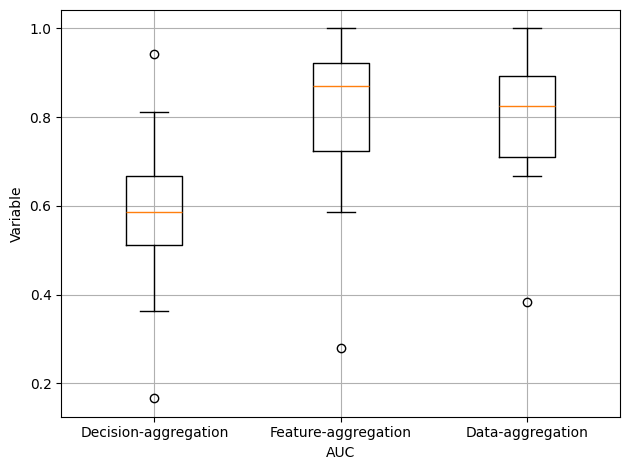

In [ ]:
plot_boxplot([auc_distribution_0, auc_distribution_1, auc_distribution_2],
             ['Decision-aggregation', 'Feature-aggregation', 'Data-aggregation'],
             'Variable',
             'AUC')
plt.show()

In [ ]:
print(np.mean(auc_distribution_2))

0.8154960938685093


In [ ]:
## we cannot really expect data aggregation to outperform feature aggregation due to the limitations of the deep neural networks

Generating ROC curve for one CNN model run...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


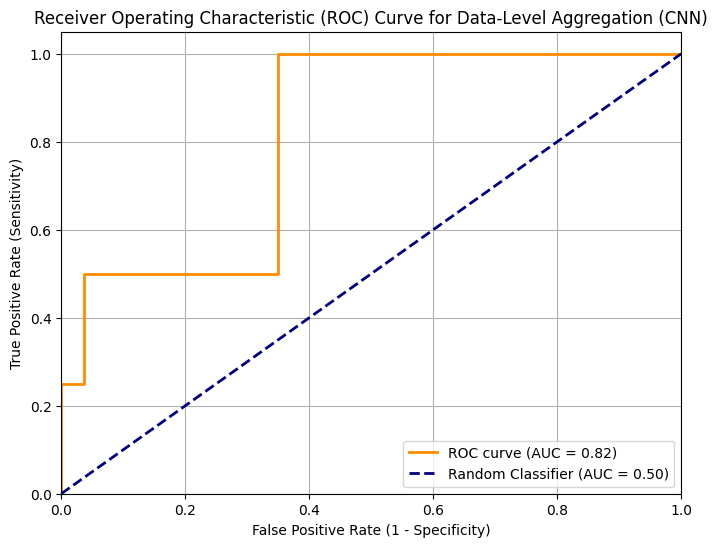

AUC for this single CNN run: 0.8163


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score # Ensure this is imported for the plot

# --- Re-define get_model here for self-containment if running separately ---
def get_model(input_shape: tuple):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


# --- Parameters for CNN ---
sample_number = 32
channel_number = 8

# --- Perform a single run to get test data and predictions for ROC curve ---
print("Generating ROC curve for one CNN model run...")

# Get a single train-test split
train_idxs_single_run, test_idxs_single_run = get_train_split(unique_patient_ids, data_idxs, data_patient_ids)

# Prepare data for this single run
train_data_single_run = []
train_labels_single_run = []
for data_index in train_idxs_single_run:
    train_data_single_run.append(data[data_index].T)
    train_labels_single_run.append(data_labels[data_index])
train_data_single_run = np.asarray(train_data_single_run)
train_labels_single_run = np.asarray(train_labels_single_run)

test_data_single_run = []
test_labels_single_run = []
for data_index in test_idxs_single_run:
    test_data_single_run.append(data[data_index].T)
    test_labels_single_run.append(data_labels[data_index])
test_data_single_run = np.asarray(test_data_single_run)
test_labels_single_run = np.asarray(test_labels_single_run)

# Instantiate and train the model
model_single_run = get_model((sample_number, channel_number))
model_single_run.fit(train_data_single_run, train_labels_single_run, epochs=10, batch_size=32, verbose=0)

# Get predictions (probabilities) on the test set
y_pred_single_run = model_single_run.predict(test_data_single_run)

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(test_labels_single_run, y_pred_single_run)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Data-Level Aggregation (CNN)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC for this single CNN run: {roc_auc:.4f}")